<a href="https://colab.research.google.com/github/ikucherevsky/DeepLearning/blob/master/GAN_anime_grayscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сделайте генератор лиц аниме на основе датасета https://www.kaggle.com/soumikrakshit/anime-faces

In [ ]:
import torch
from torch import nn
import torchvision as tv
from torchvision import datasets,transforms
import time
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kucherevskiy","key":"b0045601205279989b8a26ed266afc93"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d soumikrakshit/anime-faces

 95% 417M/441M [00:03<00:00, 104MB/s] 
100% 441M/441M [00:03<00:00, 125MB/s]


In [ ]:
! unzip anime-faces.zip

In [ ]:
BATCH_SIZE = 128
trainTransform  = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor()])
train_dataset = datasets.ImageFolder('data',transform = trainTransform)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
len(train_dataset)

21551

In [ ]:
train_dataset[123][0].shape

torch.Size([1, 64, 64])

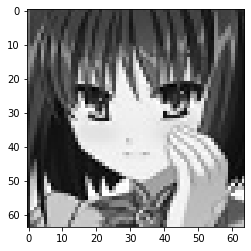

In [ ]:
plt.imshow(train_dataset[123][0].squeeze(),cmap = 'gray')

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   

In [ ]:
z_dim = 200
anime_dim = 4096

G = Generator(g_input_dim = z_dim, g_output_dim = anime_dim).to(dev)
D = Discriminator(anime_dim).to(dev)

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, anime_dim), torch.ones(BATCH_SIZE, 1)
    x_real, y_real = torch.autograd.Variable(x_real.to(dev)), torch.autograd.Variable(y_real.to(dev))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = torch.autograd.Variable(torch.randn(BATCH_SIZE, z_dim).to(dev))
    x_fake, y_fake = G(z), torch.autograd.Variable(torch.zeros(BATCH_SIZE, 1).to(dev))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.autograd.Variable(torch.randn(BATCH_SIZE, z_dim).to(dev))
    y = torch.autograd.Variable(torch.ones(BATCH_SIZE, 1).to(dev))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
n_epoch = 100
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_iter):
        if len(x) != BATCH_SIZE:
          continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/100]: loss_d: 0.755, loss_g: 1.174
[2/100]: loss_d: 0.627, loss_g: 1.539
[3/100]: loss_d: 1.271, loss_g: 2.503
[4/100]: loss_d: 0.621, loss_g: 5.692
[5/100]: loss_d: 0.176, loss_g: 10.268
[6/100]: loss_d: 0.129, loss_g: 10.776
[7/100]: loss_d: 0.047, loss_g: 14.210
[8/100]: loss_d: 0.059, loss_g: 16.776
[9/100]: loss_d: 0.187, loss_g: 14.043
[10/100]: loss_d: 0.407, loss_g: 5.202
[11/100]: loss_d: 0.362, loss_g: 5.355
[12/100]: loss_d: 0.530, loss_g: 4.519
[13/100]: loss_d: 0.577, loss_g: 4.240
[14/100]: loss_d: 0.615, loss_g: 3.887
[15/100]: loss_d: 0.823, loss_g: 2.720
[16/100]: loss_d: 0.834, loss_g: 2.663
[17/100]: loss_d: 0.827, loss_g: 2.747
[18/100]: loss_d: 0.820, loss_g: 2.732
[19/100]: loss_d: 0.785, loss_g: 2.798
[20/100]: loss_d: 0.811, loss_g: 2.764
[21/100]: loss_d: 0.816, loss_g: 2.351
[22/100]: loss_d: 0.865, loss_g: 2.290
[23/100]: loss_d: 0.868, loss_g: 2.248
[24/100]: loss_d: 0.826, loss_g: 2.324
[25/100]: loss_d: 0.773, loss_g: 2.644
[26/100]: loss_d: 0.809, loss

In [ ]:
test_z = torch.autograd.Variable(torch.randn(15, z_dim).to(dev))
generated = G(test_z)

In [ ]:
generated.shape

torch.Size([15, 4096])

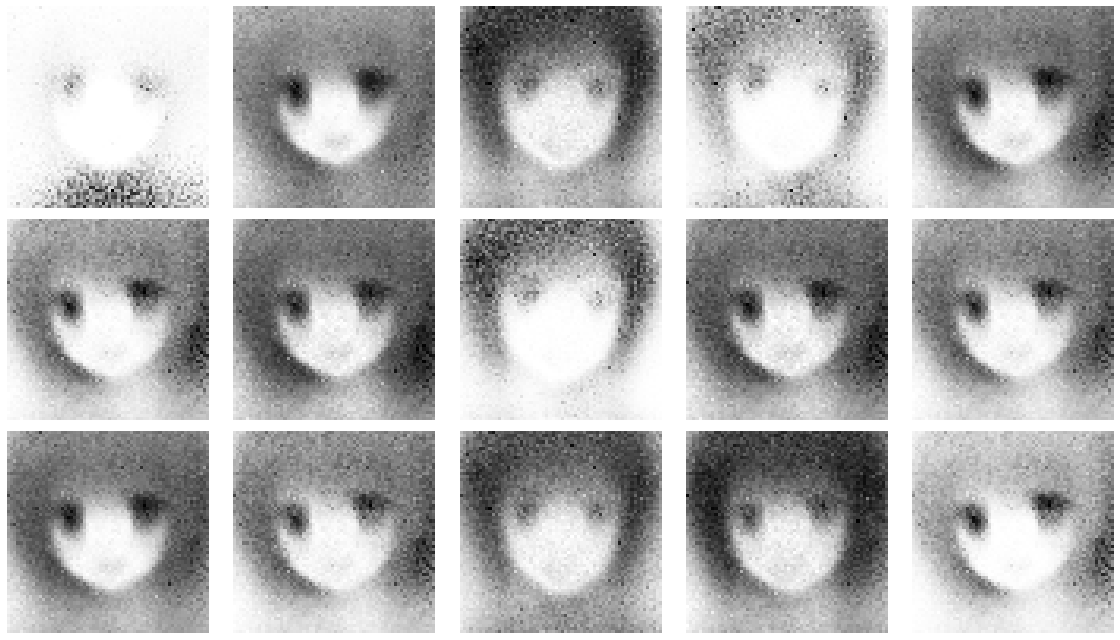

In [ ]:
plt.figure(figsize=(16,9))
for x in range(5):
  for y in range(3):
    plt.subplot(3, 5, y * 5 + x + 1)
    plt.axis('off')
    plt.imshow(generated[y * 5 + x].view(64,64).cpu().detach(),cmap='gray')
plt.tight_layout()
plt.show()